Introduces TFP syntax and variables and think about how to model a system from a Bayesian perspective.

In [3]:
from default_settings import *

In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [27]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 3.0)


### Simple Example of Poisson sampling with both tensorflow graph and eager modes

In [8]:
parameter = tfd.Exponential(rate=1., name='poisson_param').sample()
data_generator = tfd.Poisson(parameter, name='data_generator')
data_generator_sample = data_generator.sample()

if tf.executing_eagerly():
    data_gen_samps_ = tf.contrib.framework.nest.pack_sequence_as(
        data_generator_samples,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
        for t in tf.contrib.framework.nest.flatten(data_generator_samples)])
else:
    data_gen_samps_ = sess.run(data_generator_samples)
    
print('Value of sample from data generator:', data_gen_samps_)

Value of sample from data generator: 4.0


Can use the `evaluate()` function defined in `default_settings.py` to create code that's usable in both graph mode and eager model

In [7]:
# Defining our assumptions
parameter = tfd.Exponential(rate=1., name='poisson_param').sample()

# Convert our TF to numpy
[ parameter_ ] = evaluate([ parameter])

print('Sample from exponential distribution before evaluation: ', parameter)
print('Evaluated sample from exponential distribution: ', parameter_)

Sample from exponential distribution before evaluation:  Tensor("poisson_param_2/sample/Reshape:0", shape=(), dtype=float32)
Evaluated sample from exponential distribution:  0.21458682


More generally, can use `evaluate()` function to convert between the Tensorflow `tensor` data type and one that we can run operations on:

In [10]:
[
    parameter_,
    data_generator_sample_,
] = evaluate([
    parameter,
    data_generator.sample(),
])
print("'parameter_' evaluated Tensor: ", parameter_)
print("'data_generator_' sample evaluated Tensor: ", data_generator_sample_)

'parameter_' evaluated Tensor:  0.00059455424
'data_generator_' sample evaluated Tensor:  0.0


A general rule of thumb for programming in Tensorflow is that if you need to do any array-like calculations that would require Numpy functions, you should use their equivalents in TensorFLow. This practice is necessary because Numpy can produce only constant values but Tensorflow tensors are a dynamic part of the computation graph. If you mix and match these the wrong way, you will typically get an error about incompatible types.

### TFP Distributions
#### Initializing a Distribution.

In [11]:
some_distribution = tfd.Uniform(0., 4.)
sampled_tensor = some_distribution.sample()

In [12]:
sampled_tensor

<tf.Tensor 'Uniform/sample/Reshape:0' shape=() dtype=float32>

#### Deterministic variables

In [13]:
lambda_1 = tfd.Exponential(rate=1., name='lambda_1') # stochastic variable
lambda_2 = tfd.Exponential(rate=1., name='lambda_2') # stochastic variable
tau = tfd.Uniform(name='tau', low=0., high=10.) # stochastic variable

# deterministic variable since we are getting results of lambda's after sampling
new_deterministic_variable = tfd.Deterministic(name='deterministic_variable', loc=(lambda_1.sample() + lambda_2.sample()))

In [14]:
n_data_points = 5
idx = np.arange(n_data_points)

lambda_deterministic = tfd.Deterministic(tf.gather([lambda_1.sample(), lambda_2.sample()],
                                                  indices=tf.to_int32(tau.sample() >= idx)))
[lambda_deterministic_] = evaluate([lambda_deterministic.sample()])

print("{} samples from our deterministic lambda model: \n".format(n_data_points), lambda_deterministic_ )

5 samples from our deterministic lambda model: 
 [0.49821696 1.6576157  1.6576157  1.6576157  1.6576157 ]


### Including observations in the model

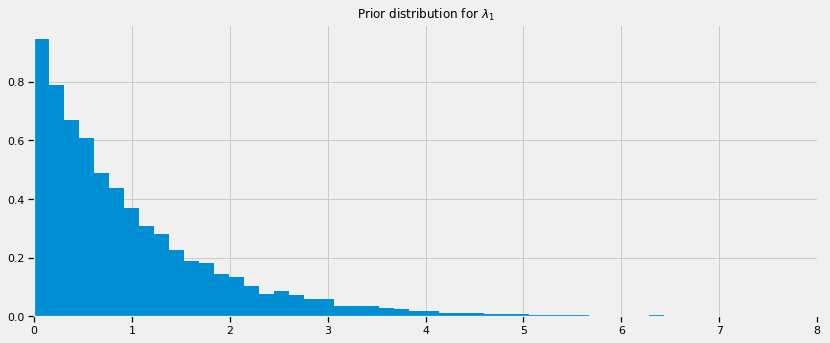

In [16]:
# Define our observed samples
lambda_1 = tfd.Exponential(rate=1., name='lambda_1')
samples = lambda_1.sample(sample_shape=20000)

# Execute graph, convert TF to Numpy
[ samples_ ] = evaluate([ samples ])

# Visualize our stepwise prior distribution
plt.figure(figsize=(12.5, 5))
plt.hist(samples_, bins=70, density=True, histtype='stepfilled')
plt.title(r"Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

In [21]:
data = tf.constant([10., 5.], dtype=tf.float32)
poisson = tfd.Poisson(rate=1./tf.reduce_mean(data))

# Execute graph
[ data_, poisson_sample_, ] = evaluate([data, poisson.sample() ])

print('two predetermined data points: ', data_)
print("\n mean of our data: ", np.mean(data_))

print("\n random sample from poisson distribution \n with the mean as the poisson's rate: \n", poisson_sample_)

two predetermined data points:  [10.  5.]

 mean of our data:  7.5

 random sample from poisson distribution 
 with the mean as the poisson's rate: 
 0.0


## Modelling approaches

A good starting thought to Bayesian modelling is to think about *how the data might have been generated*.

In [22]:
tau = tf.random_uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32)[0]

[ tau_ ] = evaluate([ tau ])

print('Value of Tau (randomly taken from DiscreteUniform(0, 80)):', tau_)

Value of Tau (randomly taken from DiscreteUniform(0, 80)): 49


In [23]:
alpha = 1./8.

lambdas = tfd.Gamma(concentration=1./alpha, rate=0.3).sample(sample_shape=[2])
[ lambda_1_, lambda_2_] = evaluate(lambdas)
print('lambda 1 (randomly taken from Gamma(α) distribution): ', lambda_1_)
print('lambda 2 (randomly taken from Gamma(α) distribution): ', lambda_2_)

lambda 1 (randomly taken from Gamma(α) distribution):  32.584953
lambda 2 (randomly taken from Gamma(α) distribution):  22.387882


In [24]:
data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau_),
                 tfd.Poisson(rate=lambda_2_).sample(sample_shape=(80-tau_))], axis=0)
days_range = tf.range(80)

[data_, days_range_] = evaluate([ data, days_range ])
print('Artifical day-by-day user SMS count created by sampling: \n', data_)

Artifical day-by-day user SMS count created by sampling: 
 [31. 32. 36. 32. 28. 29. 42. 37. 31. 27. 31. 32. 36. 24. 33. 32. 37. 35.
 29. 31. 30. 30. 31. 28. 27. 25. 27. 42. 35. 31. 37. 30. 37. 35. 37. 30.
 30. 33. 37. 32. 31. 36. 43. 24. 34. 39. 34. 15. 28. 24. 17. 16. 23. 25.
 27. 16. 17. 26. 18. 27. 21. 21. 28. 30. 24. 20. 34. 26. 21. 24. 26. 17.
 22. 23. 18. 21. 26. 21. 21. 25.]


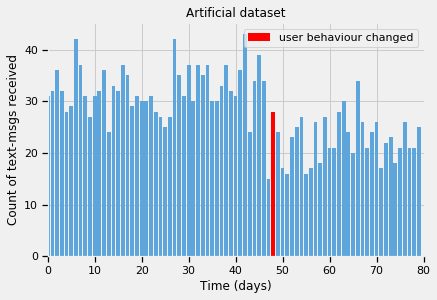

In [25]:
plt.bar(days_range_, data_, color=TFColor[3])
plt.bar(tau_ - 1, data_[tau_-1], color='r', label='user behaviour changed')
plt.xlabel('Time (days)')
plt.ylabel('Count of text-msgs received')
plt.title('Artificial dataset')
plt.xlim(0, 80)
plt.legend();

Create a few more datasets

In [30]:
def plot_artificial_sms_dataset():
    tau = tf.random_uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32)[0]
    
    alpha = 1./8.
    lambdas = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2])
    [ lambda_1_, lambda_2_ ] = evaluate(lambdas)
    data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau),
                     tfd.Poisson(rate=lambda_2_).sample(sample_shape=(80-tau))], axis=0)
    days_range = tf.range(80)
    
    [
        tau_,
        data_,
        days_range_,
    ] = evaluate([
        tau,
        data,
        days_range,
    ])
    
    plt.bar(days_range_, data_, color=TFColor[3])
    plt.bar(tau_ -1, data_[tau_-1], color='r', label='user behaviour changed')
    plt.xlim(0, 80);

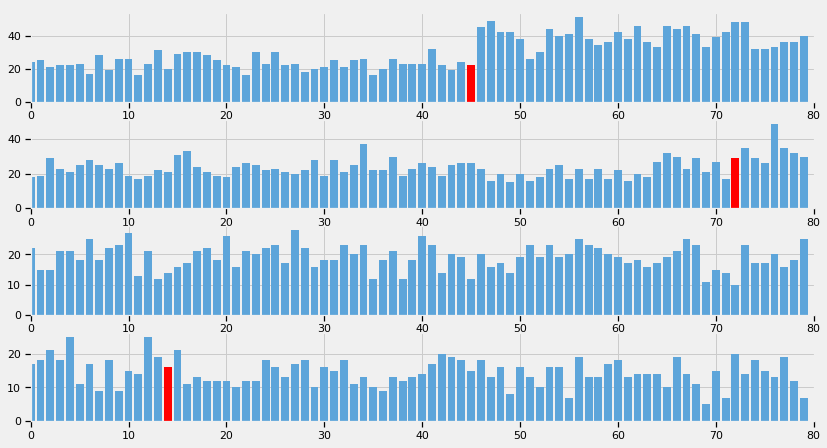

In [32]:
plt.figure(figsize=(12.5, 7))
plt.title('More example of artificial datasets')
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()